In [ ]:
COLAB = False
SAGEMAKER = True
LOAD_PRETRAIN_MODEL = True
LOAD_FINAL_MODEL = False

In [ ]:
if COLAB:
    from google.colab import drive
    drive.mount('/content/drive/')
    ROOT_PATH = '/content/drive/MyDrive/CS598-DLH-Team72/code'
if SAGEMAKER:
    ROOT_PATH = '/home/ec2-user/SageMaker'

In [ ]:
!pip install subword_nmt

In [ ]:
!pip install funcsigs

# Introduction
In the world of medicine, patients are often prescribed multiple drugs in which some sets have drug-drug interactions (DDIs). These DDIs can cause morbidity and mortality. As part of drug design and safety, researchers look to identify these interactions through computational models. However, Huang et al. (2020) point out that there are three limitations to current predictive models and propose a ChemicAl SubstrcTurE Representation (CASTER) framework to mitigate these limitations.
* First, there is no specialized representation for drugs used in DDI prediction. Current predictive models use the entire chemical representation as an input. In DDIs, what is often important is that a substructure of one drug interacts with another substructure. Finding a representation for these substructures may reduce the bias towards irrelevant parts of the chemical.
* The second limitation is the reliance on labeled training data. This reliance reduces the generalizability of the model against new drugs being developed.

* Lastly, the machine learning model’s predictions are often uninterpretable. In this project, we look to further discuss the ways in which CASTER tackles these limitations as well as verify its claims.

# Scope of Reproducibility

The project intends to reproduce the ChemicAl SubstrcTurE Representation (CASTER) framework, and test on the hypothesis below:

1.   Hypothesis 1: CASTER provides more accurate DDI prediction than other strong baselines
2.   Hypothesis 2: CASTER improves the generalizability of DDI predictions
3.   Hypothesis 3: CASTER dictionary module helps interpret its predictions



# Methodology

This methodology is the core of your project. It consists of run-able codes with necessary annotations to show the expeiment you executed for testing the hypotheses.

The methodology at least contains two subsections **data** and **model** in your experiment.

In [ ]:
import sys
default_sys_path = sys.path.copy()

# Add helper code to system path
sys.path.append(ROOT_PATH + '/CASTER/DDE/')


In [ ]:
# Import modules
import os
import torch
import copy
import warnings
import numpy as np
import pandas as pd
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.autograd import Variable
from torch.utils import data
from torch import nn
from tqdm import tqdm
from time import time
from sklearn.metrics import roc_auc_score, precision_recall_curve, \
        average_precision_score, roc_curve, auc, confusion_matrix, \
        classification_report
from sklearn.model_selection import KFold
from dde_config import dde_NN_config
from dde_torch import dde_NN_Large_Predictor
from stream_dde import supData, unsupData
from funcsigs import signature

torch.manual_seed(2)    # reproducible torch:2 np:3
np.random.seed(3)
warnings.simplefilter("ignore")
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
plt.style.use('bmh')

Matplotlib is building the font cache; this may take a moment.


##  Data
Data includes raw data (MIMIC III tables), descriptive statistics (our homework questions), and data processing (feature engineering).
  * Source of the data: where the data is collected from; if data is synthetic or self-generated, explain how. If possible, please provide a link to the raw datasets.
  * Statistics: include basic descriptive statistics of the dataset like size, cross validation split, label distribution, etc.
  * Data process: how do you munipulate the data, e.g., change the class labels, split the dataset to train/valid/test, refining the dataset.
  * Illustration: printing results, plotting figures for illustration.
  * You can upload your raw dataset to Google Drive and mount this Colab to the same directory. If your raw dataset is too large, you can upload the processed dataset and have a code to load the processed dataset.

In [ ]:
dataFolder = ROOT_PATH + '/CASTER/DDE/data'

In [ ]:
# Load SMILES for a drug-drug or drug-food pair
df_unsup = pd.read_csv(dataFolder + '/unsup_dataset.csv', names = ['idx', 'input1_SMILES', 'input2_SMILES', 'type']).drop(0)
print("Number of rows:", df_unsup.shape[0])
df_unsup.head(5)

Number of rows: 441854


,idx,input1_SMILES,input2_SMILES,type
1,202274,CCCCCCCC/C=C\CCCCCCCC(=O)OC[C@H](COP(=O)(O)OCC...,CC(O)=N[C@@H]1[C@@H](O)C=C(C(=O)O)O[C@H]1[C@H]...,df_pair
2,381808,Cc1ncc2n1-c1ccc(Cl)cc1C(c1ccccc1F)=NC2,CNCCC(Oc1ccc(C(F)(F)F)cc1)c1ccccc1,dd_pair
3,372979,O=c1oc2ccccc2c(O)c1Cc1c(O)c2ccccc2oc1=O,C=C[C@H]1CN2CC[C@H]1C[C@@H]2[C@@H](O)c1ccnc2cc...,dd_pair
4,60778,COc1c(OC)c(O)c2c(=O)cc(-c3ccc(O)cc3)oc2c1OC,CCC1=C[C@@H]2CN(C1)Cc1c([nH]c3ccccc13)[C@@](C(...,df_pair
5,196908,COC(OC)C(C)c1ccccc1,CN(C)c1cccc2c(S(=O)(=O)O)cccc12,df_pair


In [ ]:
# Load training dataset for drug-drug interaction
df_ddi = pd.read_csv(dataFolder + '/BIOSNAP/sup_train_val.csv')
df_ddi.drop(df_ddi.columns[0], axis=1, inplace=True)
print("Number of rows:", df_ddi.shape[0])
df_ddi.head(5)

Number of rows: 66432


,Drug1_ID,Drug1_SMILES,Drug2_ID,Drug2_SMILES,label
0,DB00706,CCOc1ccccc1OCCN[C@H](C)Cc1ccc(OC)c(S(N)(=O)=O)c1,DB01023,CCOC(=O)C1=C(C)NC(C)=C(C(=O)OC)C1c1cccc(Cl)c1Cl,1.0
1,3849.0,C[C@@H](Oc1ccc2[nH]nc(/C=C/c3cnn(CCO)c3)c2c1)c...,3515.0,COc1ccc2c(c1)c(CC(=O)O)c(C)n2C(=O)c1ccc(I)cc1,0.0
2,6380.0,O=P(O)(O)OCCCc1c[nH]c2ccccc12,8290.0,N[C@@H](c1ccccc1)c1ccc(-c2ncnc3[nH]cnc23)cc1,0.0
3,7947.0,CCCC(=O)O[C@]1(C(=O)COC(C)=O)CC[C@H]2[C@@H]3C[...,3010.0,CNCCc1ccccn1,0.0
4,DB00802,CCC(=O)N(c1ccccc1)C1(COC)CCN(CCn2nnn(CC)c2=O)CC1,DB00872,Cc1nc2c([nH]1)CCN(C(=O)c1ccc(NC(=O)c3ccccc3-c3...,1.0


In [ ]:
# Load training dataset for drug-drug interaction
df_ddi = pd.read_csv(dataFolder + '/BIOSNAP/sup_train_val.csv')
df_ddi.drop(df_ddi.columns[0], axis=1, inplace=True)
print("Number of rows:", df_ddi.shape[0])
df_ddi.head(5)

Number of rows: 66432


,Drug1_ID,Drug1_SMILES,Drug2_ID,Drug2_SMILES,label
0,DB00706,CCOc1ccccc1OCCN[C@H](C)Cc1ccc(OC)c(S(N)(=O)=O)c1,DB01023,CCOC(=O)C1=C(C)NC(C)=C(C(=O)OC)C1c1cccc(Cl)c1Cl,1.0
1,3849.0,C[C@@H](Oc1ccc2[nH]nc(/C=C/c3cnn(CCO)c3)c2c1)c...,3515.0,COc1ccc2c(c1)c(CC(=O)O)c(C)n2C(=O)c1ccc(I)cc1,0.0
2,6380.0,O=P(O)(O)OCCCc1c[nH]c2ccccc12,8290.0,N[C@@H](c1ccccc1)c1ccc(-c2ncnc3[nH]cnc23)cc1,0.0
3,7947.0,CCCC(=O)O[C@]1(C(=O)COC(C)=O)CC[C@H]2[C@@H]3C[...,3010.0,CNCCc1ccccn1,0.0
4,DB00802,CCC(=O)N(c1ccccc1)C1(COC)CCN(CCn2nnn(CC)c2=O)CC1,DB00872,Cc1nc2c([nH]1)CCN(C(=O)c1ccc(NC(=O)c3ccccc3-c3...,1.0


Label counts in training data:
 1.0    33243
0.0    33189
Name: label, dtype: int64


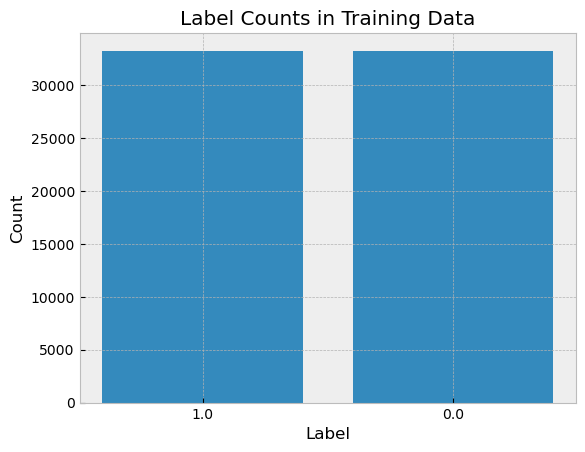

In [ ]:
# Count occurrences of each unique value in the "label" column
value_counts = df_ddi['label'].value_counts()

print("Label counts in training data:\n", value_counts)

# Plot the bar plot
plt.bar([str(x) for x in value_counts.keys()], value_counts.values)

# Title and labels
plt.title('Label Counts in Training Data')
plt.xlabel('Label')
plt.ylabel('Count')

# Show plot
plt.show()

##   Model
The model includes the model definitation which usually is a class, model training, and other necessary parts.
  * Model architecture: layer number/size/type, activation function, etc
  * Training objectives: loss function, optimizer, weight of each loss term, etc
  * Others: whether the model is pretrained, Monte Carlo simulation for uncertainty analysis, etc
  * The code of model should have classes of the model, functions of model training, model validation, etc.
  * If your model training is done outside of this notebook, please upload the trained model here and develop a function to load and test it.

### Code

In [ ]:
def test_dde_nn(data_generator, model_nn):
    """
    Evaluate the model, return roc_auc_score and prediction labels.
    """
    y_pred = []
    y_label = []
    model_nn.eval()
    for i, (v_D, label) in enumerate(data_generator):
        recon, code, score, Z_f, z_D = model_nn(v_D.float().cuda())
        m = torch.nn.Sigmoid()
        logits = torch.squeeze(m(score)).detach().cpu().numpy()
        label_ids = label.to('cpu').numpy()
        y_label = y_label + label_ids.flatten().tolist()
        y_pred = y_pred + logits.flatten().tolist()

    return roc_auc_score(y_label, y_pred), y_pred


def main_dde_nn():
    """
    Train DDE NN model, steps:
    1. Load config
    2. Data preparation: split training/validation/testing set
    3. Pre-training: auto-encoding module to construct latent feature embedding for drug-drug paris
    4. Train the classification model with deep dictionary module.
    """
    print("--- Load Configs --- ")
    config = dde_NN_config()
    pretrain_epoch = config['pretrain_epoch']
    pretrain_epoch = 0
    train_epoch = 2 #9
    lr = config['LR']
    thr = config['recon_threshold']
    recon_loss_coeff = config['reconstruction_coefficient']
    proj_coeff = config['projection_coefficient']
    lambda1 = config['lambda1']
    lambda2 = config['lambda2']
    BATCH_SIZE = config['batch_size']

    loss_r_history = [] # Reconstruction loss in auto-encoding module
    loss_p_history = [] # Projection lossin deep dictionary module
    loss_c_history = [] # Binary Cross Entropy loss for label
    loss_history = []

    #model_nn = dde_NN_Large_Predictor(**config)
    path = ROOT_PATH + '/CASTER/DDE/model_pretrain_checkpoint_1_copy.pt'
    model_nn = torch.load(path)

    model_nn.cuda()

    if torch.cuda.device_count() > 1:
        print("Let's use", torch.cuda.device_count(), "GPUs!")
        # model_nn = nn.DataParallel(model_nn)

    opt = torch.optim.Adam(model_nn.parameters(), lr = lr)

    print('--- Data Preparation ---')

    params = {'batch_size': BATCH_SIZE,
              'shuffle': True,
              'num_workers': 6}

    #k-fold
    kf = KFold(n_splits = 8, shuffle = True, random_state = 3)

    #get the 1st fold index
    fold_index = next(kf.split(df_ddi), None)

    ids_unsup = df_unsup.index.values
    partition_sup = {'train': fold_index[0], 'val': fold_index[1]}
    labels_sup = df_ddi.label.values

    unsup_set = unsupData(ids_unsup, df_unsup)
    unsup_generator = data.DataLoader(unsup_set, **params)

    training_set = supData(partition_sup['train'], labels_sup, df_ddi)
    training_generator_sup = data.DataLoader(training_set, **params)

    validation_set = supData(partition_sup['val'], labels_sup, df_ddi)
    validation_generator_sup = data.DataLoader(validation_set, **params)

    max_auc = 0
    model_max = copy.deepcopy(model_nn)

    print('--- Pre-training Starts ---')
    torch.backends.cudnn.benchmark = True
    len_unsup = len(unsup_generator)
    for pre_epo in range(pretrain_epoch):
        for i, v_D in enumerate(unsup_generator):
            v_D = v_D.float().cuda()
            recon, code, score, Z_f, z_D = model_nn(v_D)
            loss_r = recon_loss_coeff * F.binary_cross_entropy(recon, v_D.float())

            loss_p = proj_coeff * (torch.norm(z_D - torch.matmul(code, Z_f)) + lambda1 * torch.sum(torch.abs(code)) / BATCH_SIZE + lambda2 * torch.norm(Z_f, p='fro') / BATCH_SIZE)
            loss = loss_r + loss_p

            loss_r_history.append(loss_r)
            loss_p_history.append(loss_p)
            loss_history.append(loss)

            opt.zero_grad()
            loss.backward()
            opt.step()

            if(i % 10 == 0):
                print('Pre-Training at Epoch ' + str(pre_epo) + ' iteration ' + str(i) + ', total loss is '
                      + '%.3f' % (loss.cpu().detach().numpy()) + ', proj loss is ' + '%.3f' % (loss_p.cpu().detach().numpy())
                      + ', recon loss is ' + '%.3f' % (loss_r.cpu().detach().numpy()))

            if loss_r < thr:
                # smaller than certain reconstruction error, -> go to training step
                break

            if i == int(len_unsup/4):
                torch.save(model_nn, 'model_pretrain_checkpoint_1.pt')
            if i == int(len_unsup/2):
                torch.save(model_nn, 'model_pretrain_checkpoint_1.pt')
        torch.save(model_nn, 'model_nn_pretrain.pt')

    print('--- Device Handling ---')
    # Code version / Device Handling
    model_nn.device_ids = list(range(torch.cuda.device_count()))
    model_nn.src_device_obj = torch.device("cuda:{}".format(model_nn.device_ids[0]))

    #model_nn.cuda()  # Move the entire model to GPU
    model_nn.to("cuda:0")

    # Move each parameter of the model to GPU if not already there
    for param in model_nn.parameters():
        if param.device != torch.device('cuda:0'):
            param.data = param.data.to(torch.device('cuda:0'))
            if param._grad is not None:
                param._grad.data = param._grad.data.to(torch.device('cuda:0'))

    print('--- Go for Training ---')
    if not LOAD_FINAL_MODEL:
        for tr_epo in range(train_epoch):
            for i, (v_D, label) in enumerate(training_generator_sup):
                v_D = v_D.float().cuda()
                recon, code, score, Z_f, z_D = model_nn(v_D)

                label = Variable(torch.from_numpy(np.array(label)).long())
                loss_fct = torch.nn.BCELoss()
                m = torch.nn.Sigmoid()
                n = torch.squeeze(m(score))

                loss_c = loss_fct(n, label.float().cuda())
                loss_r = recon_loss_coeff * F.binary_cross_entropy(recon, v_D.float())

                loss_p = proj_coeff * (torch.norm(z_D - torch.matmul(code, Z_f)) + lambda1 * torch.sum(torch.abs(code)) / BATCH_SIZE + lambda2 * torch.norm(Z_f, p='fro') / BATCH_SIZE)

                loss = loss_c + loss_r + loss_p
                loss_r_history.append(loss_r)
                loss_p_history.append(loss_p)
                loss_c_history.append(loss_c)
                loss_history.append(loss)

                opt.zero_grad()
                loss.backward()
                opt.step()

                if(i % 20 == 0):
                    print('Training at Epoch ' + str(tr_epo) + ' iteration ' + str(i) + ', total loss is ' + '%.3f' % (loss.cpu().detach().numpy()) + ', proj loss is ' + '%.3f' %(loss_p.cpu().detach().numpy()) + ', recon loss is ' + '%.3f' %(loss_r.cpu().detach().numpy()) + ', classification loss is ' + '%.3f' % (loss_c.cpu().detach().numpy()))

            with torch.set_grad_enabled(False):
                auc, logits = test_dde_nn(validation_generator_sup, model_nn)
                if auc > max_auc:
                    model_max = copy.deepcopy(model_nn)
                    max_auc = auc
                    path = 'model_train_checkpoint_SNAP_EarlyStopping_SemiSup_Full_Run3.pt'
                    torch.save(model_nn, path)
                print('Test at Epoch '+ str(tr_epo) + ' , AUC: '+ str(auc))

        return model_max, loss_c_history, loss_r_history, loss_p_history, loss_history

    else:
        path = ROOT_PATH + '/model_train_checkpoint_SNAP_EarlyStopping_SemiSup_Full_Run3.pt'
        model_nn = torch.load(path)
        model_nn.device_ids = list(range(torch.cuda.device_count()))
        model_nn.src_device_obj = torch.device("cuda:{}".format(model_nn.device_ids[0]))

        #model_nn.cuda()  # Move the entire model to GPU
        model_nn.to("cuda:0")

        # Move each parameter of the model to GPU if not already there
        for param in model_nn.parameters():
            if param.device != torch.device('cuda:0'):
                param.data = param.data.to(torch.device('cuda:0'))
                if param._grad is not None:
                    param._grad.data = param._grad.data.to(torch.device('cuda:0'))

        return model_nn, loss_c_history, loss_r_history, loss_p_history, loss_history

In [ ]:
if __name__ == '__main__':
    model_max, loss_c, loss_r, loss_p, loss = main_dde_nn()
    pass

--- Load Configs --- 
Let's use 8 GPUs!
--- Data Preparation ---
--- Pre-training Starts ---
--- Device Handling ---
--- Go for Training ---
Training at Epoch 0 iteration 0, total loss is 0.708, proj loss is 0.010, recon loss is 0.005, classification loss is 0.692
Training at Epoch 0 iteration 20, total loss is 0.596, proj loss is 0.098, recon loss is 0.005, classification loss is 0.493
Training at Epoch 0 iteration 40, total loss is 0.461, proj loss is 0.070, recon loss is 0.005, classification loss is 0.386
Training at Epoch 0 iteration 60, total loss is 0.449, proj loss is 0.098, recon loss is 0.005, classification loss is 0.346
Training at Epoch 0 iteration 80, total loss is 0.378, proj loss is 0.068, recon loss is 0.005, classification loss is 0.305
Training at Epoch 0 iteration 100, total loss is 0.288, proj loss is 0.055, recon loss is 0.005, classification loss is 0.228
Training at Epoch 0 iteration 120, total loss is 0.344, proj loss is 0.076, recon loss is 0.005, classificati

# Results
In this section, you should finish training your model training or loading your trained model. That is a great experiment! You should share the results with others with necessary metrics and figures.

Please test and report results for all experiments that you run with:

*   specific numbers (accuracy, AUC, RMSE, etc)
*   figures (loss shrinkage, outputs from GAN, annotation or label of sample pictures, etc)


#### Loss Shrinkage

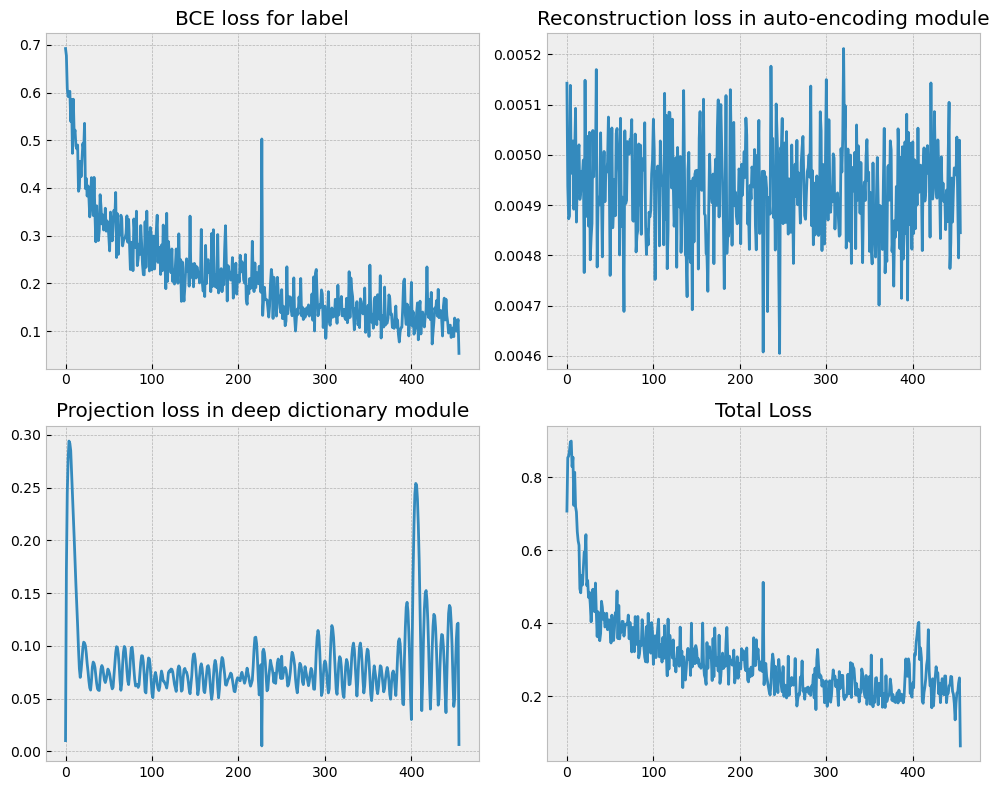

In [ ]:
loss_c = torch.tensor(loss_c)
loss_r = torch.tensor(loss_r)
loss_p = torch.tensor(loss_p)
loss = torch.tensor(loss)

# Create a figure and a grid of subplots
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))

# Plot the data on each subplot
axes[0, 0].plot(loss_c.cpu())
axes[0, 0].set_title('BCE loss for label')
axes[0, 1].plot(loss_r.cpu())
axes[0, 1].set_title('Reconstruction loss in auto-encoding module')
axes[1, 0].plot(loss_p.cpu())
axes[1, 0].set_title('Projection loss in deep dictionary module')
axes[1, 1].plot(loss.cpu())
axes[1, 1].set_title('Total Loss')

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()

#### Evaluation on Testing Set

In [ ]:
params = {'batch_size': 256,
          'shuffle': True,
          'num_workers': 6}

# Testing DDI Dataframe
df_ddi_test = pd.read_csv(dataFolder + '/BIOSNAP/sup_test.csv')
labels_sup = df_ddi_test.label.values
test_set = supData(df_ddi_test.index.values, labels_sup, df_ddi_test)
test_generator_sup = data.DataLoader(test_set, **params)

model_nn = model_max

y_pred = []
y_label = []
model_nn.eval()

for i, (v_D, label) in tqdm(enumerate(test_generator_sup)):
    recon, code, score, Z_f, z_D = model_nn(v_D.float())
    m = torch.nn.Sigmoid()
    logits = torch.squeeze(m(score)).detach().cpu().numpy()
    label_ids = label.to('cpu').numpy()
    y_label = y_label + label_ids.flatten().tolist()
    y_pred = y_pred + logits.flatten().tolist()

65it [01:27,  1.34s/it]


In [ ]:
print("Average Precision Score:", average_precision_score(y_label, y_pred))

Average Precision Score: 0.9816159306157923


Text(0.5, 1.0, '2-class Precision-Recall curve: AP=0.98')

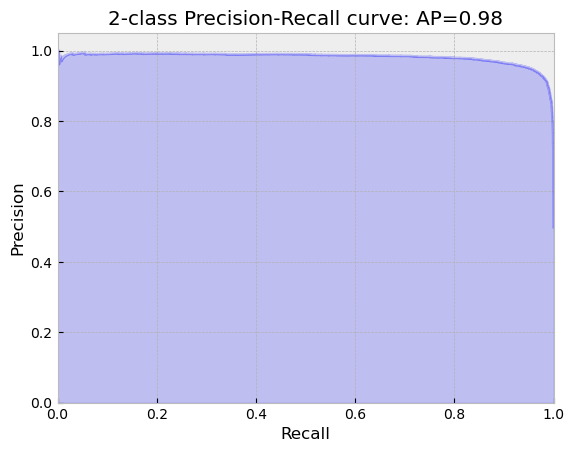

In [ ]:
average_precision = average_precision_score(y_label, y_pred)
precision, recall, _ = precision_recall_curve(y_label, y_pred)

# In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})
plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(
          average_precision))

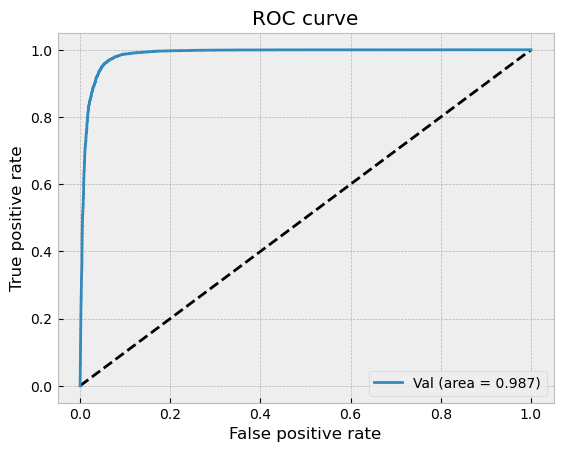

In [ ]:
# ROC Curve
fpr, tpr, thresholds = roc_curve(y_label, y_pred)
auc_score = auc(fpr, tpr)

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='Val (area = {:.3f})'.format(auc_score))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')

In [ ]:
params = {'batch_size': 256,
          'shuffle': True,
          'num_workers': 6}

# Testing DDI Dataframe
df_ddi_test = pd.read_csv(dataFolder + '/BIOSNAP/sup_test.csv')
labels_sup = df_ddi_test.label.values
test_set = supData(df_ddi_test.index.values, labels_sup, df_ddi_test)
test_generator_sup = data.DataLoader(test_set, **params)

model_nn = model_max


y_pred = []
y_label = []
model_nn.eval()

for i, (v_D, label) in tqdm(enumerate(test_generator_sup)):
    recon, code, score, Z_f, z_D = model_nn(v_D.float())
    m = torch.nn.Sigmoid()
    logits = torch.squeeze(m(score)).detach().cpu().numpy()
    label_ids = label.to('cpu').numpy()
    y_label = y_label + label_ids.flatten().tolist()
    y_pred = y_pred + logits.flatten().tolist()

65it [01:00,  1.07it/s]


In [ ]:
print("Average Precision Score:", average_precision_score(y_label, y_pred))

Average Precision Score: 0.9816159509681222


Text(0.5, 1.0, '2-class Precision-Recall curve: AP=0.98')

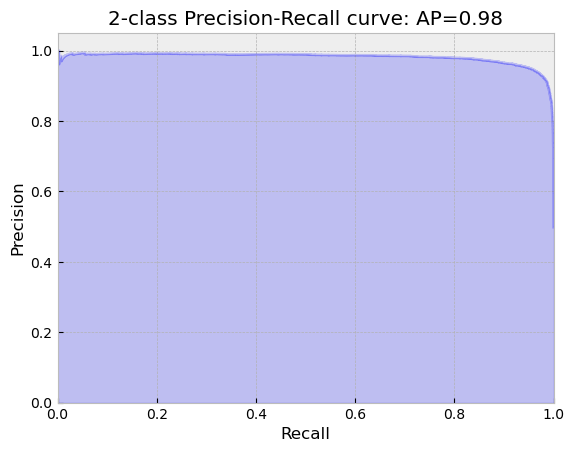

In [ ]:
average_precision = average_precision_score(y_label, y_pred)
precision, recall, _ = precision_recall_curve(y_label, y_pred)

# In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})
plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(
          average_precision))